# Consumer Complaints Classification with LSTM

In [1]:
import pandas as pd 

df = pd.read_excel('consumer complaints BOA_CA.xlsx')
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,2013-09-10,Mortgage,Home equity loan or line of credit,"Application, originator, mortgage broker",NaN,NaN,NaN,Bank of America,CA,90605,NaN,NaN,Web,2013-09-10,Closed with explanation,Yes,No,521395
1,2013-09-10,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,NaN,Bank of America,CA,93436,NaN,NaN,Web,2013-09-10,Closed with explanation,Yes,No,521415
2,2013-08-30,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Bank of America,CA,90036,NaN,NaN,Web,2013-09-04,Closed with explanation,Yes,Yes,510043
3,2013-09-24,Credit card,NaN,Billing disputes,NaN,NaN,NaN,Bank of America,CA,92251,NaN,NaN,Phone,2013-09-25,Closed with non-monetary relief,Yes,No,540488
4,2013-09-17,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,Bank of America,CA,91761,NaN,NaN,Referral,2013-09-18,Closed with explanation,Yes,Yes,531085


## Complaint Labels

In [2]:
Product = pd.Series(df['product']).value_counts()
tb = pd.DataFrame(Product)
tb.reset_index(inplace=True)
tb.columns = ['Label', 'Number of Complaints']
# tb

[Text(0, 0.5, '')]

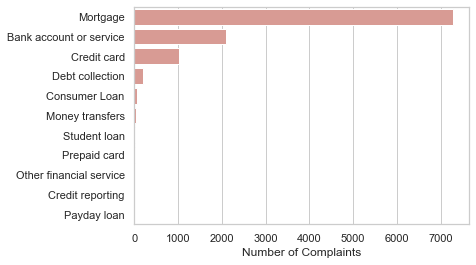

In [3]:
import seaborn as sns

sns.set(style = 'whitegrid')
ax = sns.barplot(y = 'Label', x = 'Number of Complaints', data = tb, color = 'salmon', saturation = 0.5)
ax.set(ylabel = '')

## Complaint Narratives

In [4]:
df2 = df.dropna(subset=['consumer_complaint_narrative'])
df2.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
2339,2015-03-19,Mortgage,Other mortgage,Settlement process and costs,NaN,I Want to file a complaint about Bank of Ameri...,Company chooses not to provide a public response,Bank of America,CA,926XX,NaN,Consent provided,Web,2015-03-25,Closed with explanation,Yes,No,1290963
2340,2015-03-19,Mortgage,Conventional fixed mortgage,Settlement process and costs,NaN,I got behind in payments and worked with B of ...,Company chooses not to provide a public response,Bank of America,CA,926XX,NaN,Consent provided,Web,2015-03-19,Closed with monetary relief,Yes,No,1291084
2343,2015-03-19,Bank account or service,Checking account,Deposits and withdrawals,NaN,"This bank of america, gave all my money withou...",Company chooses not to provide a public response,Bank of America,CA,907XX,NaN,Consent provided,Web,2015-03-19,Closed with explanation,Yes,Yes,1291225
2345,2015-03-19,Bank account or service,Savings account,"Account opening, closing, or management",NaN,I have made many mistakes when I was younger a...,Company chooses not to provide a public response,Bank of America,CA,914XX,NaN,Consent provided,Web,2015-03-19,Closed with explanation,Yes,No,1291551
2387,2015-03-20,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,I refinanced my home and chose to preserve my ...,Company chooses not to provide a public response,Bank of America,CA,941XX,NaN,Consent provided,Web,2015-03-23,Closed with explanation,Yes,Yes,1293518


[Text(0, 0.5, '')]

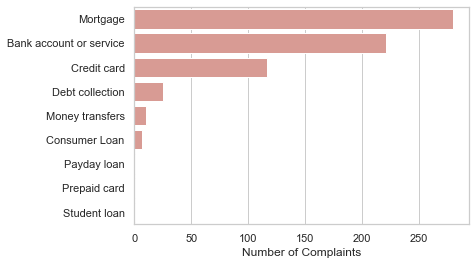

In [5]:
Product = pd.Series(df2['product']).value_counts()
tb2 = pd.DataFrame(Product)
tb2.reset_index(inplace=True)
tb2.columns = ['Label', 'Number of Complaints']
# tb

sns.set(style = 'whitegrid')
ax = sns.barplot(y = 'Label', x = 'Number of Complaints', data = tb2, color = 'salmon', saturation = 0.5)
ax.set(ylabel = '')

## Text Pre-processing

In [6]:
def clean_narrative(sample):
    """
    function to clean consumer complaint narratives 
        sample: one complaint narrative 
        return: narrative after clean   
    """
    sample = sample.lower()
    sample = sample.translate({ord(c): "" for c in "[xx!@#$%^&*()[]{};:'\/\n<>?\|`~-=_+.,\"]"})
    return sample

In [7]:
df2['consumer_complaint_narrative'] = df2['consumer_complaint_narrative'].apply(clean_narrative)

## LSTM

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_word_database = 50000
max_complaint_length = 250
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_word_database, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df2['consumer_complaint_narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 6938 unique tokens.
Using TensorFlow backend.


In [9]:
X = tokenizer.texts_to_sequences(df2['consumer_complaint_narrative'].values)
X = pad_sequences(X, maxlen = max_complaint_length)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (663, 250)


In [10]:
Y = pd.get_dummies(df2['product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (663, 9)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(596, 250) (596, 9)
(67, 250) (67, 9)


In [12]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(max_word_database, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

In [13]:
epochs = 5
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
9/9 [==============================] - 5s 509ms/step - loss: 2.1582 - accuracy: 0.3358 - val_loss: 2.0080 - val_accuracy: 0.4333
Epoch 2/5
9/9 [==============================] - 4s 413ms/step - loss: 1.6534 - accuracy: 0.4086 - val_loss: 1.0866 - val_accuracy: 0.4500
Epoch 3/5
9/9 [==============================] - 4s 464ms/step - loss: 1.3967 - accuracy: 0.3451 - val_loss: 1.1449 - val_accuracy: 0.4333
Epoch 4/5
9/9 [==============================] - 4s 442ms/step - loss: 1.3384 - accuracy: 0.4086 - val_loss: 1.1055 - val_accuracy: 0.4333
Epoch 5/5
9/9 [==============================] - 4s 403ms/step - loss: 1.3237 - accuracy: 0.4478 - val_loss: 1.1028 - val_accuracy: 0.4833


In [14]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3/3 [==============================] - 0s 27ms/step - loss: 1.2485 - accuracy: 0.5224
Test set
  Loss: 1.248
  Accuracy: 0.522
